In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import cv2

import pickle
from keras.preprocessing.image import ImageDataGenerator, DirectoryIterator
import matplotlib.ticker as ticker
from keras.utils import to_categorical
from keras.applications.inception_v3 import InceptionV3
from vit_keras import vit
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from vit_keras.layers import ClassToken, AddPositionEmbs, TransformerBlock
from keras.layers import LayerNormalization

import tensorflow.keras.backend as K
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import BatchNormalization

from sklearn.metrics import confusion_matrix
from typing import Dict, List
import itertools

from image_load import *
from keras.models import load_model

from keras_flops import get_flops

from plotting import loss_accuracy_graph_from_pickle, bar_accuracy_plot, scatter_plot, confusion_matrices


C:\Users\Rutger\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow_addons\utils\tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
#load trained models:
model_names = ["resnet", "inception", "vgg16", "b16", "b32"]
model_dict = {}


model_dict["resnet"] = load_model("models and histories/resnet_model.h5")
model_dict["inception"] = load_model("models and histories/inception_model.h5")
model_dict["vgg16"] = load_model("models and histories/vgg16_model.h5")

model_dict["b16"] = load_model("models and histories/b16_model.h5")
model_dict["b32"] = load_model("models and histories/b32_model.h5")

In [3]:
#final data loading
resnet_history = pickle.load(open("data_final/resnet_history.pickle","rb"))
inception_history = pickle.load(open("data_final/inception_history.pickle","rb"))
vgg_history = pickle.load(open("data_final/vgg16_history.pickle","rb"))

vitb16_history = pickle.load(open("data_final/b16_history.pickle","rb"))
vitb32_history = pickle.load(open("data_final/b32_history.pickle","rb"))

data_dict = pickle.load(open("data_final/data_dictionary.pickle","rb"))

In [4]:
#reformatting data

names = ["resnet","inception", "vgg", "b16", "b32"]
histories = [resnet_history,inception_history, vgg_history, vitb16_history, vitb32_history]
hist_dict = {}
epochs = 60
k_folds = 5
for name, history in zip(names, histories):
    loss = np.zeros(epochs)
    val_loss = np.zeros(epochs)
    acc = np.zeros(epochs)
    val_acc = np.zeros(epochs)
    for fold_idx in range(k_folds):
        loss = np.add(loss, history[fold_idx]["loss"])
        val_loss = np.add(val_loss, history[fold_idx]["val_loss"])
        acc = np.add(acc, history[fold_idx]["binary_accuracy"])
        val_acc = np.add(val_acc, history[fold_idx]["val_binary_accuracy"])
        
    hist_dict[name] = [loss/k_folds, val_loss/k_folds, acc/k_folds, val_acc/k_folds]    

  

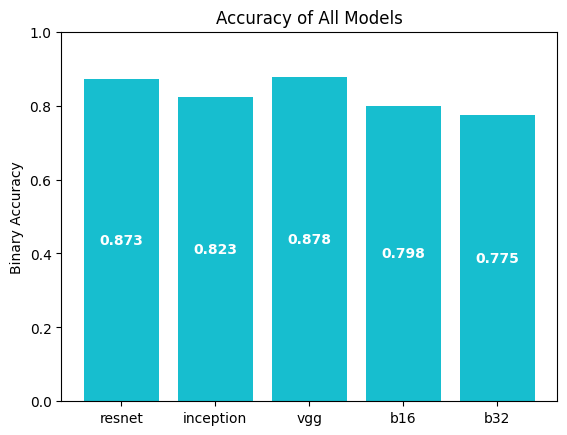

In [5]:
acc_loss_dict = {}

for name, values in hist_dict.items():
    acc_loss_dict[name] = [np.max(values[3]), np.max(values[1])]
    
bar_accuracy_plot(acc_loss_dict)
    



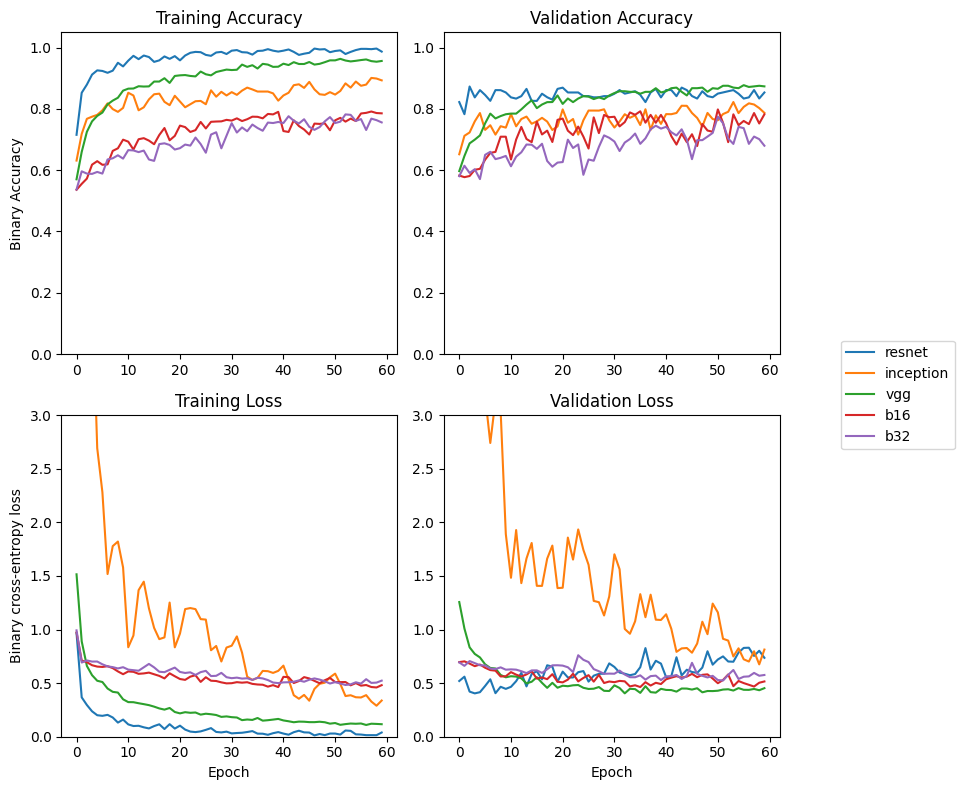

<Figure size 2200x2200 with 0 Axes>

In [6]:
# make loss and accuracy learning plots

loss_accuracy_graph_from_pickle(hist_dict)


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.
 resnet,non_train_weight: 23587712| trainable_weights: 2100226 | FLOPS: 7.755396748 G
 inception,non_train_weight: 21802784| trainable_weights: 2100226 | FLOPS: 5.69757262 G
 vgg16,non_train_weight: 14714688| trainable_weights: 1026 | FLOPS: 30.712957442 G
 b16,non_train_weight: 0.0| trainable_weights: 85800194 | FLOPS: 35.243032601 G
 b32,non_train_weight: 0.0| trainable_weights: 87456770 | FLOPS: 8.840161064 G


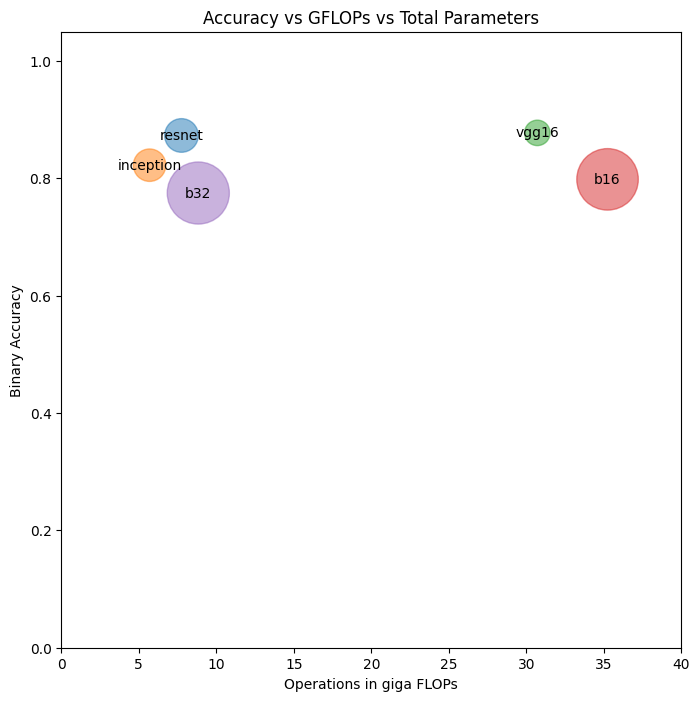

In [7]:
flops_dict = {}

for name, model in model_dict.items():
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    flops = get_flops(model)
    flops = flops / 10 ** 9
    print(f" {name},non_train_weight: {non_trainable_count}| trainable_weights: {trainable_count} | FLOPS: {flops} G")
    flops_dict[name] = flops

    
scatter_plot(model_dict, acc_loss_dict, flops_dict, dot_scalar = 2000)

model: resnet
2/2 [==============================] - 7s 2s/step
model: inception
2/2 [==============================] - 5s 1s/step
model: vgg16
2/2 [==============================] - 12s 5s/step
model: b16
2/2 [==============================] - 27s 8s/step
model: b32
2/2 [==============================] - 10s 2s/step


<Figure size 2000x3500 with 0 Axes>

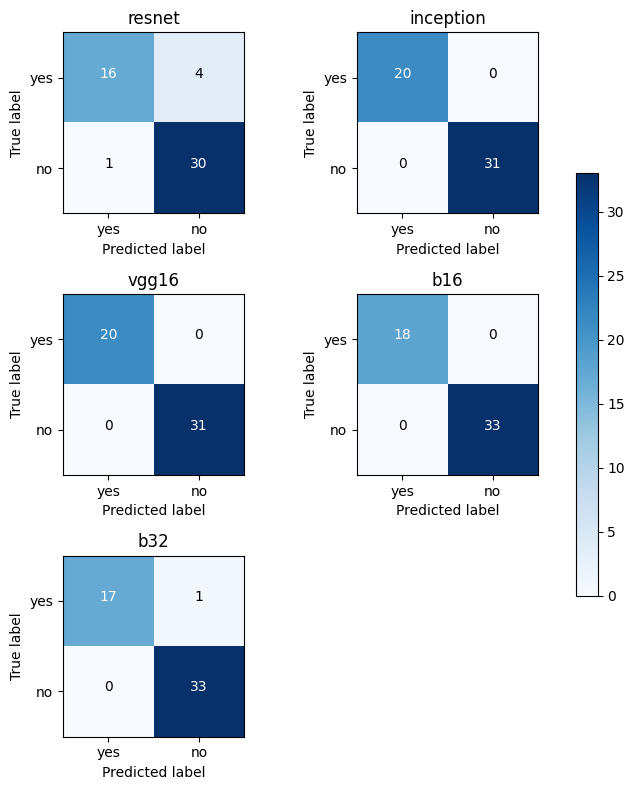

In [8]:
#confusion matrices
test_data_dict = {}

for name, values in data_dict.items():
    x_test = values[0]
    y_test = np.argmax(values[1], axis=1)
    test_data_dict[name] = [x_test, y_test]
    
    
    
confusion_matrices(model_dict, test_data_dict)